# Time Series Prediction

In [162]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [163]:
# Load dataset
ro_data = pd.read_pickle("ro_data.pkl")
ro_data.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,time_diff,is_large_gap,group
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,...,0.06,390,0.769231,0,0,1,2017-12-22 10:49:41,NaT,False,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,0.06,390,0.646154,0,0,1,2017-12-22 10:50:12,0 days 00:00:31,False,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,0.06,390,0.519231,0,0,1,2017-12-22 10:50:42,0 days 00:00:30,False,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,0.09,390,0.388462,0,0,1,2017-12-22 10:51:13,0 days 00:00:31,False,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,0.06,390,0.253846,0,0,1,2017-12-22 10:51:44,0 days 00:00:31,False,1


In [164]:
ro_data.dtypes

Date                             object
Time                             object
S1_Temp                         float64
S2_Temp                         float64
S3_Temp                         float64
S4_Temp                         float64
S1_Light                          int64
S2_Light                          int64
S3_Light                          int64
S4_Light                          int64
S1_Sound                        float64
S2_Sound                        float64
S3_Sound                        float64
S4_Sound                        float64
S5_CO2                            int64
S5_CO2_Slope                    float64
S6_PIR                            int64
S7_PIR                            int64
Room_Occupancy_Count              int64
Datetime                 datetime64[ns]
time_diff               timedelta64[ns]
is_large_gap                       bool
group                             int64
dtype: object

## Feature Engineering

In [165]:
# Setting predictive horizon to 5 steps ahead
ph = 5

# Setting up a column with future occupancy count for convenience
ro_data['Room_Occupancy_Future_{}'.format(ph)] = ro_data['Room_Occupancy_Count'].shift(-ph)

# Shifting creates some rows with NaN values, so dropping those
ro_data.dropna(inplace=True)

ro_data.head()


,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,...,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count,Datetime,time_diff,is_large_gap,group,Room_Occupancy_Future_5
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,...,390,0.646154,0,0,1,2017-12-22 10:50:12,0 days 00:00:31,False,1,1.0
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,...,390,0.519231,0,0,1,2017-12-22 10:50:42,0 days 00:00:30,False,1,1.0
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,...,390,0.388462,0,0,1,2017-12-22 10:51:13,0 days 00:00:31,False,1,1.0
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,...,390,0.253846,0,0,1,2017-12-22 10:51:44,0 days 00:00:31,False,1,1.0
5,2017/12/22,10:52:14,25.00,24.81,24.56,25.44,121,34,54,40,...,390,0.165385,0,0,1,2017-12-22 10:52:14,0 days 00:00:30,False,1,1.0


## Train/Test split

In [166]:
# Using the second half of group 1 as testing data because it has a good distribution of occupancy counts
group_1_data = ro_data[ro_data['group'] == 1]
split_index = len(group_1_data) // 2  # Midpoint of group 1

# Define training and testing sets
test_data = group_1_data.iloc[split_index:]  # Second half of group 1 as test set
train_data = ro_data[~ro_data.index.isin(test_data.index)]  # All other data as training set

# Features selected based on correlation analysis in eda-data-clean.ipynb notebook
features = ['S1_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound', 
            'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR']
target = 'Room_Occupancy_Future_5'

X_train, y_train = train_data[features], train_data[target]
X_test, y_test = test_data[features], test_data[target]

# Reshape target variable to match LSTM output requirements
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Display the new training and test set sizes
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((7471, 9), (2652, 9), (7471, 1), (2652, 1))

## Model

In [167]:
# Helper function to standardize evaluating models
# We are evaluating our models based on the following metrics:
#     Mean Absolute Error
#     Mean Squared Error
#     Coefficient of Determination(R^2 score)
# Parameters:
#     model: Trained LSTM model
#     X_test: Test features
#     y_test: Actual values of the target variable
def evaluate_lstm_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Convert y_test to NumPy array (if not already)
    y_test = np.array(y_test)

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("\n** Model Evaluation Metrics **")
    print(f"  - MAE: {mae:.4f}")
    print(f"  - MSE: {mse:.4f}")
    print(f"  - RMSE: {rmse:.4f}")
    print(f"  - R² Score: {r2:.4f}\n")

    # Visualization: Predicted vs Actual for First 100 Samples
    plt.figure(figsize=(12, 6))
    plt.plot(y_test, label="Actual (t+5)", linestyle="dashed")
    plt.plot(y_pred, label="Predicted (t+5)")
    
    plt.xlabel("Sample Index")
    plt.ylabel("Room Occupancy Count")
    plt.legend()
    plt.title("Predicted vs Actual Occupancy Counts")
    plt.show()

    # Residual Distribution Plot
    # residuals = y_test - y_pred
    # plt.figure(figsize=(10, 5))
    # sns.histplot(residuals.flatten(), bins=30, kde=True)
    # plt.xlabel("Prediction Error (Residual)")
    # plt.title("Residual Distribution")
    # plt.show()


Epoch 1/50


/Users/alejandromarchini/.pyenv/versions/3.9.16/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6333 - mae: 0.3219 - mse: 0.6333 - val_loss: 0.1007 - val_mae: 0.1465 - val_mse: 0.1007
Epoch 2/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1342 - mae: 0.1396 - mse: 0.1342 - val_loss: 0.0829 - val_mae: 0.1237 - val_mse: 0.0829
Epoch 3/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1052 - mae: 0.1179 - mse: 0.1052 - val_loss: 0.0810 - val_mae: 0.1200 - val_mse: 0.0810
Epoch 4/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0953 - mae: 0.1084 - mse: 0.0953 - val_loss: 0.0840 - val_mae: 0.1233 - val_mse: 0.0840
Epoch 5/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0758 - mae: 0.1009 - mse: 0.0758 - val_loss: 0.0902 - val_mae: 0.1233 - val_mse: 0.0902
Epoch 6/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0678 - mae: 0.0967 - mse: 0.0678 - val_loss: 0.0927 - val_mae: 0.1231 - val_mse: 0.0927
Epoch 7/50
234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0781 - mae: 0.0970 - mse: 0.0781 - val_loss: 0.09

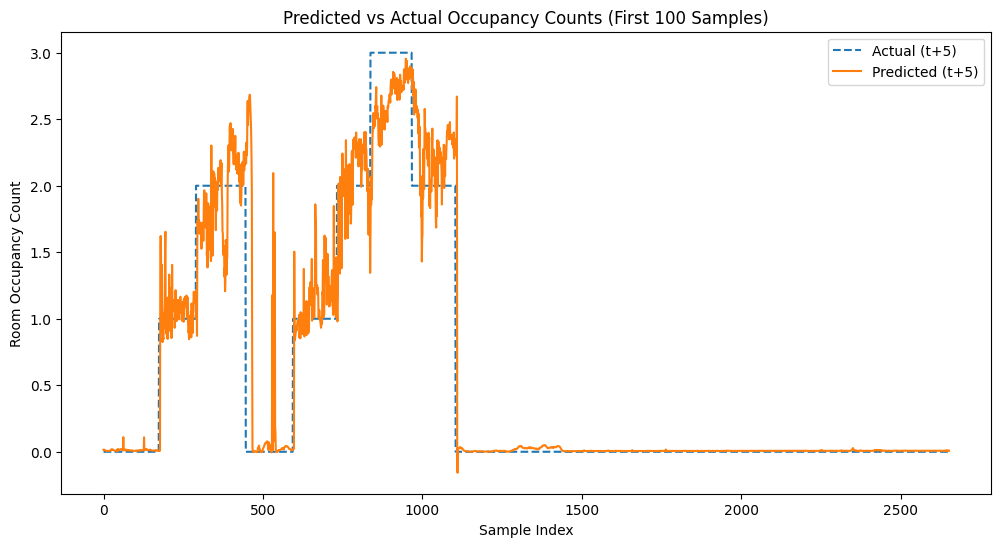

In [168]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape input data for LSTM: (samples, timesteps, features)
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define LSTM model
model = Sequential()

# Using relu to avoid vanishing gradient problem
model.add(LSTM(64, activation='relu', return_sequences=True, input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))

model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

# Train the model
model.fit(X_train_reshaped, y_train, epochs=50, batch_size=32, validation_data=(X_test_reshaped, y_test))

# Evaluate the model
evaluate_lstm_model(model, X_test_reshaped, y_test)
